In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from skopt import Optimizer
from skopt.space import Real

In [3]:
# 1️⃣ Load UCI Concrete dataset
data = fetch_openml(name="Concrete_Compressive_Strength", as_frame=True)
X = data.data.values
y = data.target.values

print(f"Dataset shape: X = {X.shape}, y = {y.shape}")

/home/mjoudy/.local/lib/python3.10/site-packages/sklearn/datasets/_openml.py:292: UserWarning: Multiple active versions of the dataset matching the name concrete_compressive_strength exist. Versions may be fundamentally different, returning version 7.
  warn(


Dataset shape: X = (1030, 8), y = (1030,)


In [10]:
# 2️⃣ Scale features to [0, 1] (important for GP and BO)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define parameter space for BO (8 dimensions, all in [0, 1])
space = [Real(0.0, 1.0, name=f'feature_{i}') for i in range(X_scaled.shape[1])]

# 3️⃣ Define "objective function" — simulating experiment
# We take a point x (scaled), map to real space, and fit nearest neighbor to get y.

# For simplicity, here we simulate this using a "lookup" — in real life this would be an experiment.

# Simple trick: use nearest neighbor in dataset (simulate expensive experiment)
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=1)
nn.fit(X_scaled)

def concrete_strength_simulation(x_scaled):
    x_scaled = np.array(x_scaled).reshape(1, -1)
    dist, idx = nn.kneighbors(x_scaled)
    strength = y[idx[0][0]]
    return -strength  # We minimize negative strength (maximize strength)


def concrete_strength_discrete(index):
    index = int(index[0])  # skopt passes index as array
    strength = y[index]
    return -strength  # Minimize negative strength

In [5]:
# 4️⃣ Initialize Optimizer
opt = Optimizer(
    dimensions=space,
    base_estimator="GP",
    acq_func="EI",
    random_state=42
)

In [6]:
# 5️⃣ Run Batch Bayesian Optimization
n_iterations = 20
batch_size = 3

X_total = []
y_total = []

for i in range(n_iterations):
    X_batch = opt.ask(n_points=batch_size)
    y_batch = [concrete_strength_simulation(x) for x in X_batch]
    opt.tell(X_batch, y_batch)
    
    X_total.extend(X_batch)
    y_total.extend(y_batch)
    
    print(f"Iteration {i+1}/{n_iterations} - Best strength so far: {-np.min(y_total):.2f} MPa")

Iteration 1/20 - Best strength so far: 56.62 MPa
Iteration 2/20 - Best strength so far: 73.30 MPa
Iteration 3/20 - Best strength so far: 73.30 MPa
Iteration 4/20 - Best strength so far: 74.36 MPa
Iteration 5/20 - Best strength so far: 74.36 MPa
Iteration 6/20 - Best strength so far: 74.36 MPa
Iteration 7/20 - Best strength so far: 74.36 MPa
Iteration 8/20 - Best strength so far: 74.36 MPa
Iteration 9/20 - Best strength so far: 82.60 MPa
Iteration 10/20 - Best strength so far: 82.60 MPa
Iteration 11/20 - Best strength so far: 82.60 MPa
Iteration 12/20 - Best strength so far: 82.60 MPa
Iteration 13/20 - Best strength so far: 82.60 MPa
Iteration 14/20 - Best strength so far: 82.60 MPa
Iteration 15/20 - Best strength so far: 82.60 MPa
Iteration 16/20 - Best strength so far: 82.60 MPa
Iteration 17/20 - Best strength so far: 82.60 MPa
Iteration 18/20 - Best strength so far: 82.60 MPa
Iteration 19/20 - Best strength so far: 82.60 MPa
Iteration 20/20 - Best strength so far: 82.60 MPa


In [7]:
# Convert to numpy
X_total = np.array(X_total)
y_total = np.array(y_total)


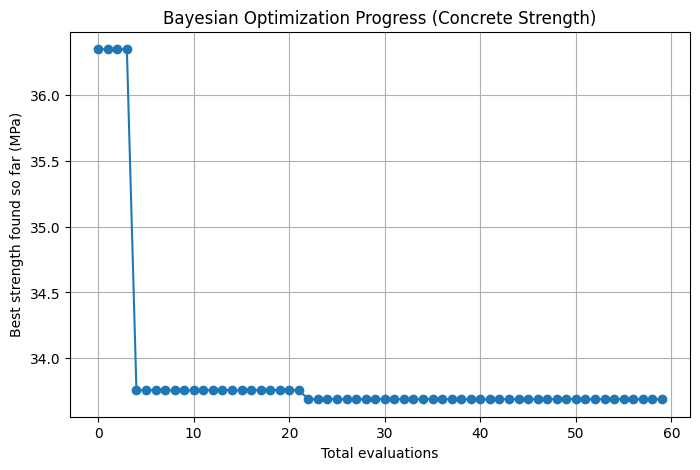

In [8]:
# 6️⃣ Plot convergence
plt.figure(figsize=(8, 5))
plt.plot(np.minimum.accumulate(-y_total), marker='o')
plt.xlabel("Total evaluations")
plt.ylabel("Best strength found so far (MPa)")
plt.title("Bayesian Optimization Progress (Concrete Strength)")
plt.grid(True)
plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from skopt import Optimizer
from skopt.space import Categorical

# For extra visualizations:
import pandas as pd
from pandas.plotting import parallel_coordinates
import seaborn as sns

# 1️⃣ Load UCI Concrete dataset
data = fetch_openml(name="Concrete_Compressive_Strength", as_frame=True)
X = data.data.values
y = data.target.values

print(f"Dataset shape: X = {X.shape}, y = {y.shape}")

# 2️⃣ Scale features to [0, 1] (optional, but we do it for uniformity)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 3️⃣ Treat dataset as **discrete set of options** (index 0..N-1)
N = X_scaled.shape[0]
indices = np.arange(N)

# Define BO space: Categorical over dataset indices
space = [Categorical(categories=list(indices), name="index")]

# 4️⃣ Define objective function
def concrete_strength_discrete(index):
    index = int(index[0])  # skopt passes index as array
    strength = y[index]
    return -strength  # Minimize negative strength

# 5️⃣ Initialize Optimizer
opt = Optimizer(
    dimensions=space,
    base_estimator="GP",
    acq_func="EI",
    random_state=42
)

# 6️⃣ Run BO loop
n_iterations = 30  # Since discrete, can do more iterations
batch_size = 1     # One sample per iteration, like a real experiment

chosen_indices = []
chosen_strengths = []

for i in range(n_iterations):
    X_batch = opt.ask(n_points=batch_size)
    y_batch = [concrete_strength_discrete(x) for x in X_batch]
    opt.tell(X_batch, y_batch)
    
    chosen_indices.extend([int(x[0]) for x in X_batch])
    chosen_strengths.extend(y_batch)
    
    print(f"Iteration {i+1}/{n_iterations} - Best strength so far: {-np.min(chosen_strengths):.2f} MPa")


/home/mjoudy/.local/lib/python3.10/site-packages/sklearn/datasets/_openml.py:292: UserWarning: Multiple active versions of the dataset matching the name concrete_compressive_strength exist. Versions may be fundamentally different, returning version 7.
  warn(


Dataset shape: X = (1030, 8), y = (1030,)
Iteration 1/30 - Best strength so far: 31.81 MPa
Iteration 2/30 - Best strength so far: 35.23 MPa
Iteration 3/30 - Best strength so far: 37.96 MPa
Iteration 4/30 - Best strength so far: 37.96 MPa
Iteration 5/30 - Best strength so far: 37.96 MPa
Iteration 6/30 - Best strength so far: 74.17 MPa
Iteration 7/30 - Best strength so far: 74.17 MPa
Iteration 8/30 - Best strength so far: 74.17 MPa
Iteration 9/30 - Best strength so far: 74.17 MPa
Iteration 10/30 - Best strength so far: 74.17 MPa
Iteration 11/30 - Best strength so far: 74.17 MPa
Iteration 12/30 - Best strength so far: 74.17 MPa
Iteration 13/30 - Best strength so far: 74.17 MPa
Iteration 14/30 - Best strength so far: 74.17 MPa
Iteration 15/30 - Best strength so far: 74.17 MPa
Iteration 16/30 - Best strength so far: 74.17 MPa
Iteration 17/30 - Best strength so far: 74.17 MPa
Iteration 18/30 - Best strength so far: 74.17 MPa
Iteration 19/30 - Best strength so far: 74.17 MPa
Iteration 20/30 -

/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [756] before, using random point [870]
  warnings.warn(


Iteration 21/30 - Best strength so far: 74.17 MPa
Iteration 22/30 - Best strength so far: 74.17 MPa
Iteration 23/30 - Best strength so far: 74.17 MPa
Iteration 24/30 - Best strength so far: 74.17 MPa


/home/mjoudy/miniconda3/envs/bbo_env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [756] before, using random point [756]
  warnings.warn(


Iteration 25/30 - Best strength so far: 74.17 MPa
Iteration 26/30 - Best strength so far: 78.80 MPa
Iteration 27/30 - Best strength so far: 78.80 MPa
Iteration 28/30 - Best strength so far: 78.80 MPa
Iteration 29/30 - Best strength so far: 78.80 MPa
Iteration 30/30 - Best strength so far: 78.80 MPa


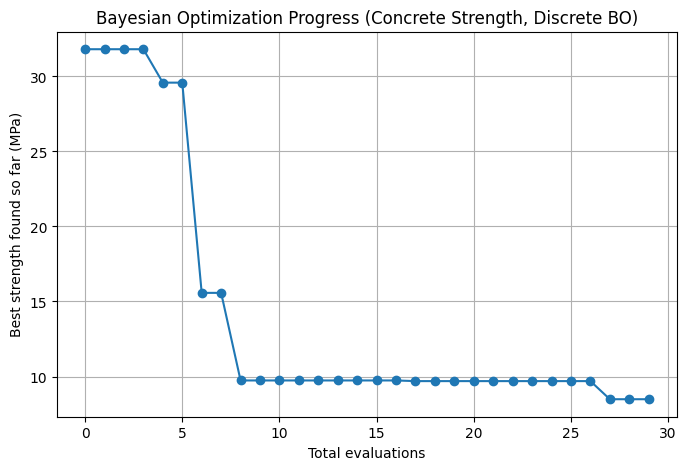

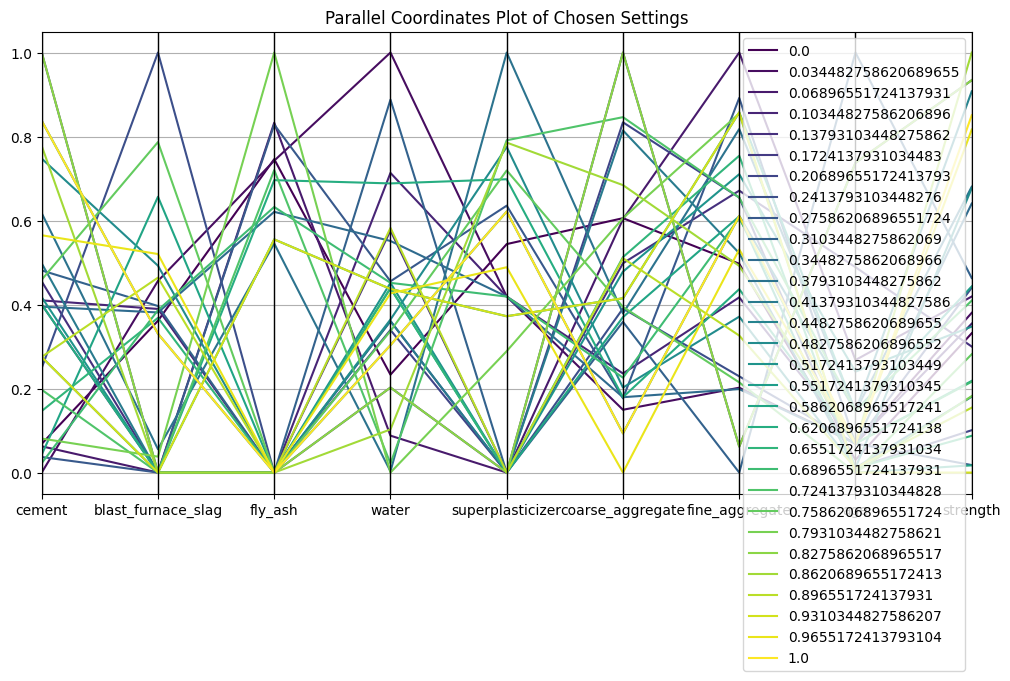

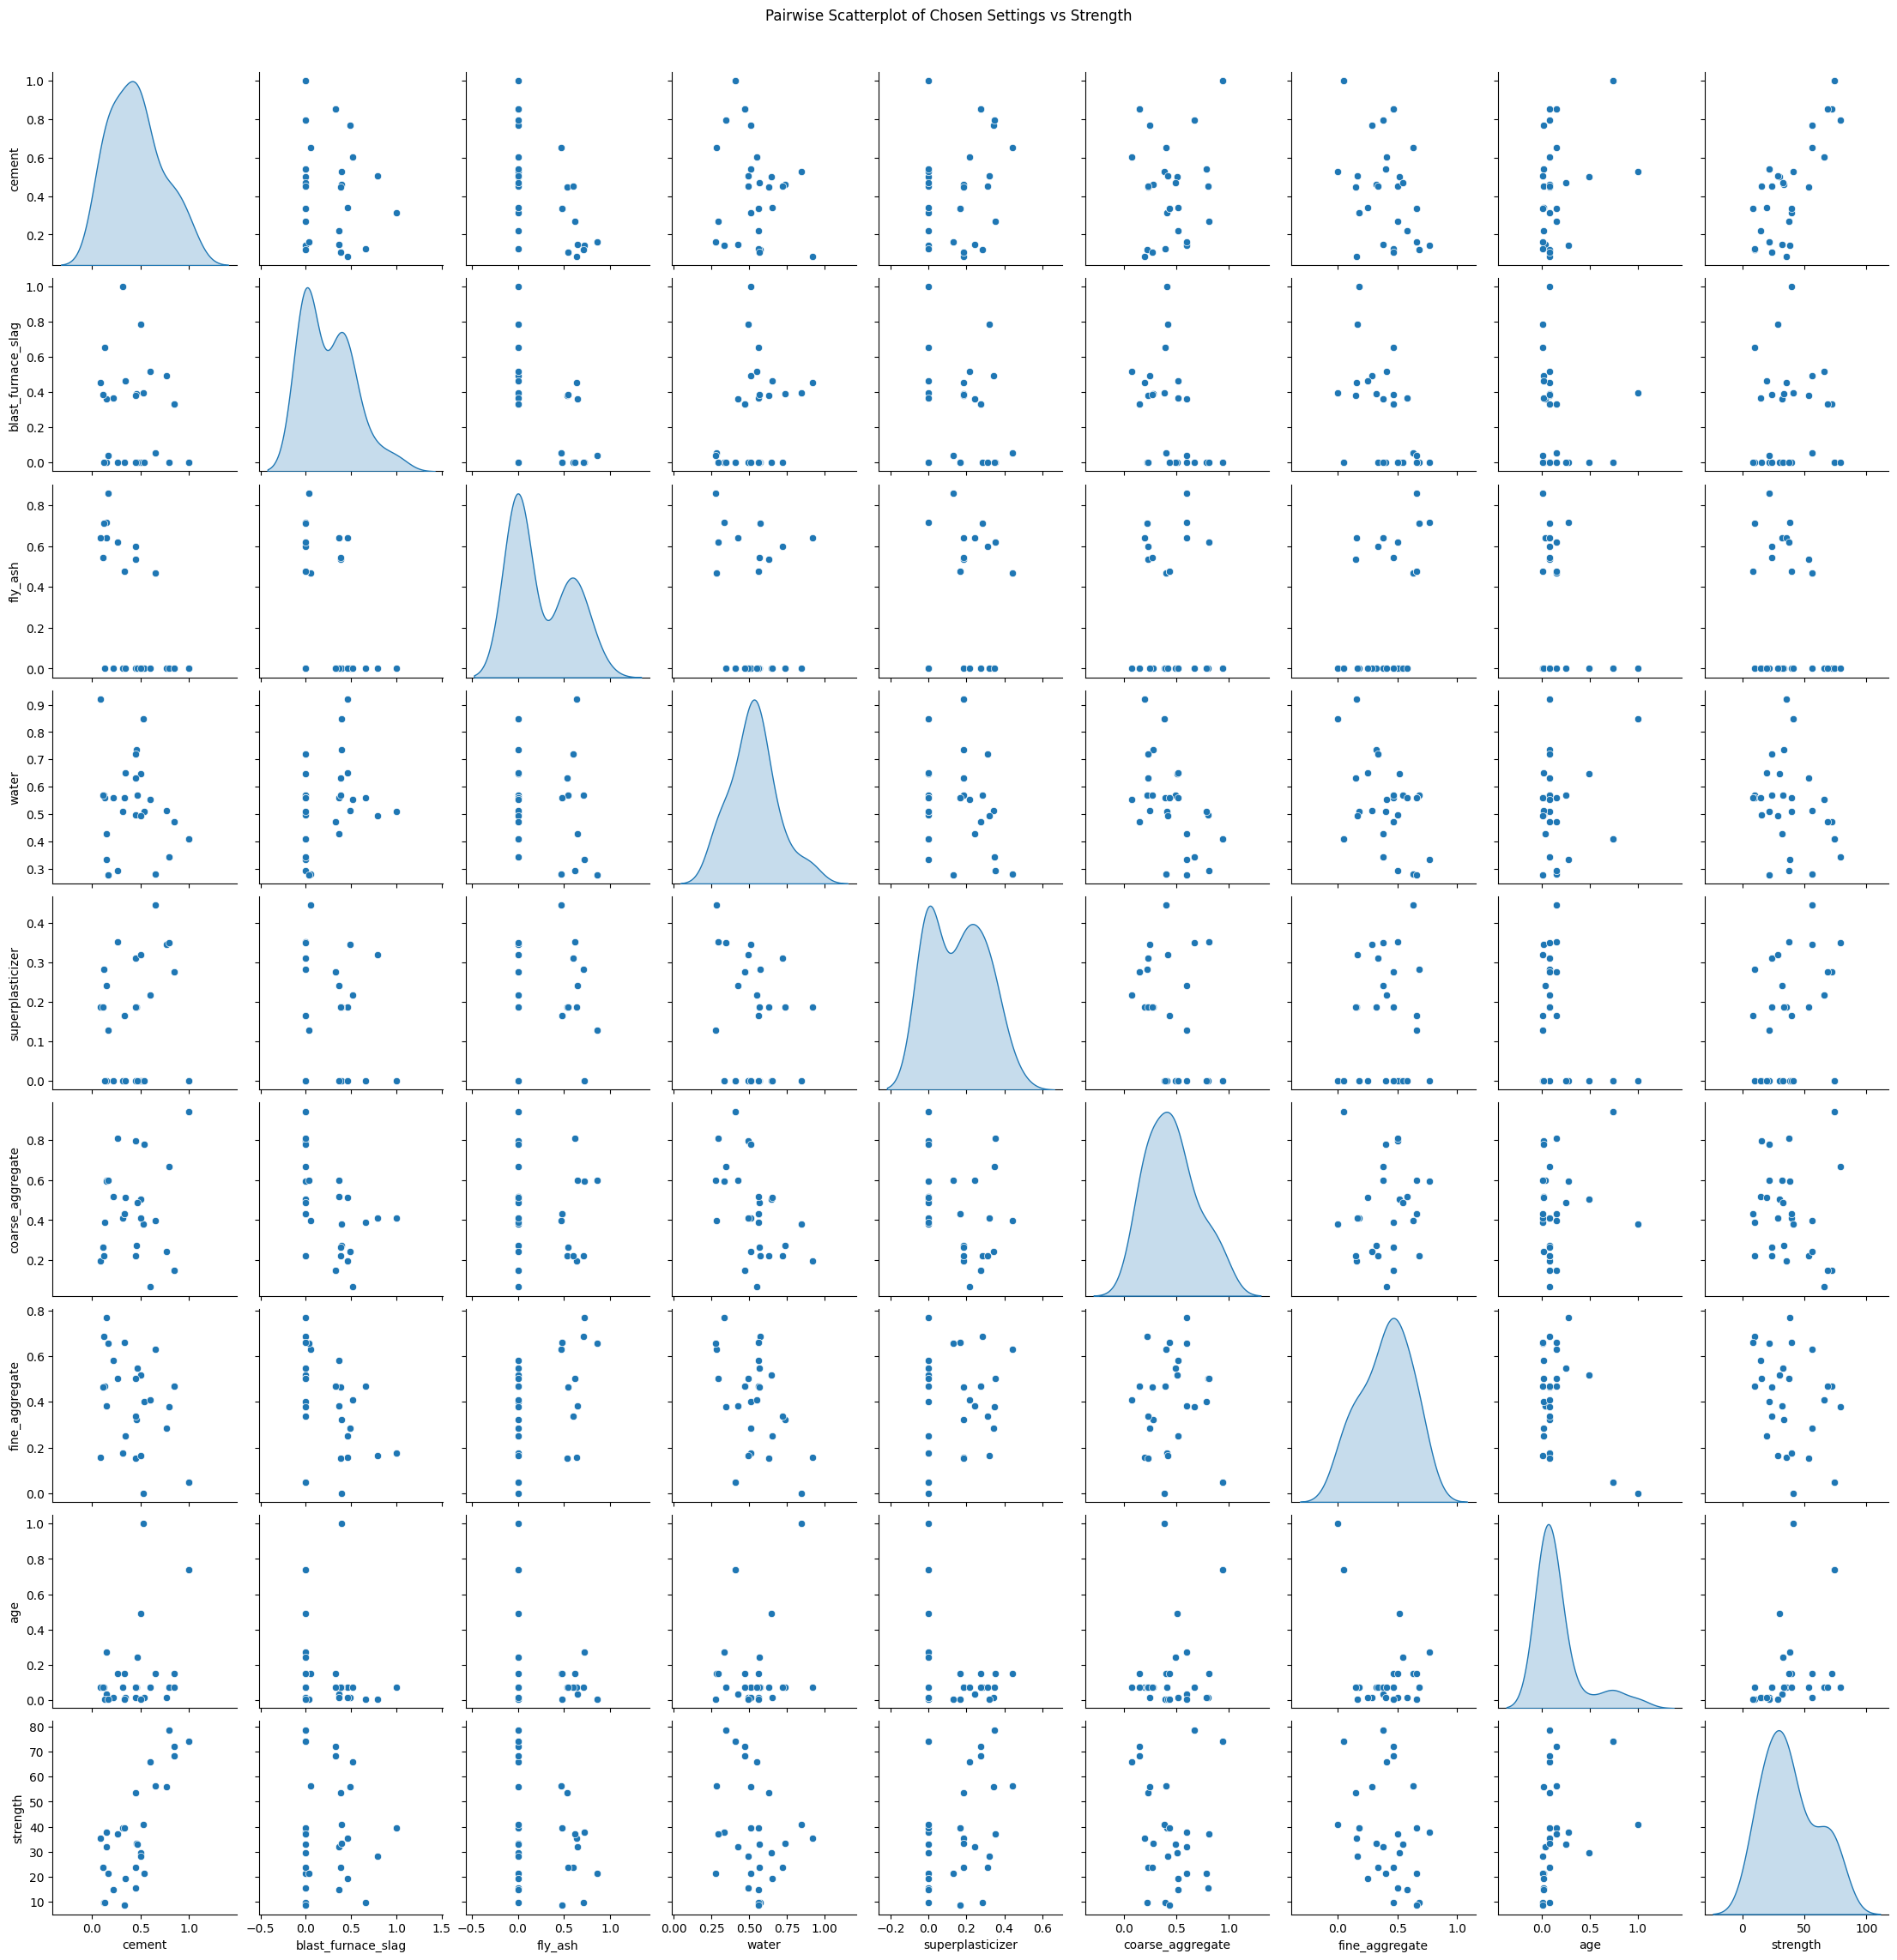


Top 10 best configurations found:
     strength  iteration    cement  blast_furnace_slag   fly_ash     water  \
25  78.800212         25  0.796804            0.000000  0.000000  0.345309   
5   74.166933          5  1.000000            0.000000  0.000000  0.409182   
24  74.166933         24  1.000000            0.000000  0.000000  0.409182   
13  72.298453         13  0.851598            0.330551  0.000000  0.473852   
29  68.299493         29  0.851598            0.330551  0.000000  0.473852   
28  65.907011         28  0.602740            0.520312  0.000000  0.552894   
11  56.337084         11  0.650685            0.055648  0.469765  0.281437   
14  56.095767         14  0.769406            0.492487  0.000000  0.512974   
10  53.524022         10  0.447489            0.381191  0.534733  0.632735   
9   41.052780          9  0.526256            0.396494  0.000000  0.848303   

    superplasticizer  coarse_aggregate  fine_aggregate       age  
25          0.349379          0.665698 

In [17]:
# === VISUALIZATIONS ===

# 7️⃣ Convergence plot
plt.figure(figsize=(8, 5))
plt.plot(np.minimum.accumulate(-np.array(chosen_strengths)), marker='o')
plt.xlabel("Total evaluations")
plt.ylabel("Best strength found so far (MPa)")
plt.title("Bayesian Optimization Progress (Concrete Strength, Discrete BO)")
plt.grid(True)
plt.show()

# 8️⃣ Parallel Coordinates Plot
df_chosen = pd.DataFrame(
    X_scaled[chosen_indices], 
    columns=data.feature_names
)
df_chosen["strength"] = -np.array(chosen_strengths)
df_chosen["iteration"] = np.arange(len(chosen_indices))

# Normalize for plotting (optional, helps parallel coordinates)
df_norm = (df_chosen - df_chosen.min()) / (df_chosen.max() - df_chosen.min())

plt.figure(figsize=(12, 6))
parallel_coordinates(df_norm, class_column="iteration", colormap=plt.cm.viridis)
plt.title("Parallel Coordinates Plot of Chosen Settings")
plt.show()

# 9️⃣ Pairwise scatterplot
df_eval = pd.DataFrame(X_scaled[chosen_indices], columns=data.feature_names)
df_eval["strength"] = -np.array(chosen_strengths)

sns.pairplot(df_eval, diag_kind='kde')
plt.suptitle("Pairwise Scatterplot of Chosen Settings vs Strength", y=1.02)
plt.show()

# 🔟 Table of best results (Top 10)
df_best = df_eval.copy()
df_best["iteration"] = np.arange(len(chosen_indices))
df_best = df_best.sort_values(by="strength", ascending=False)
print("\nTop 10 best configurations found:")
print(df_best.head(10)[["strength", "iteration"] + list(data.feature_names)])


In [18]:
space

[Categorical(categories=(0, 1, 2, ..., 1027, 1028, 1029), prior=None)]